# **Objektum-detektálás közepes felbontású (Sentinel-2) műholdképeken**

Az alábbiakban bemutatott modell a RetinaNet nevezetű objektum-detektáló hálózat fastai implementációja alapján készült. A felhasznált adatsor Sentinel-2 műholdképek 2560 méter oldalhosszúságú kivágatából áll.

fastai implementáció: https://github.com/fastai/course-v3/blob/master/nbs/dl2/pascal.ipynb

Készítette: Taró Bence, SZTE-TTIK Geográfus (MSc), 2020.04.02.

![alt text](https://www.mdpi.com/sensors/sensors-19-00281/article_deploy/html/images/sensors-19-00281-g004.png)

A RetinaNet szerkezetének vázlata. (a) A ResNet és a Feature Pyramid Network jelenti a "gerincét" a hálózatnak. (b) A formák detektálását szolgáló osztályozó és regressziós alhálózatok.

# **Adatok előkészítése**

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.imports import *
from fastai.callbacks import *
from fastai.basics import *
from fastai import *
import torch
from pathlib import Path
from zipfile import ZipFile
import os, sys
import json

In [ ]:
#feltöltés
from google.colab import files

uploaded = files.upload()

In [ ]:
#kicsomagolás
filename = "VOC_1class_2.zip"

with ZipFile(filename, 'r') as zipp:
  zipp.extractall()
  print('Done')

Done


In [ ]:
import sys
path = Path('/content/data_sved_2/JPEGImages')

In [ ]:
#cwd megadása
%cd /content/data_sved_2/JPEGImages/

/content/data_sved_2/JPEGImages


In [ ]:
#json annotációk betöltése
annots = json.load(open('/content/data_sved_2/output_alloviz.json'))

In [ ]:
annots.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [ ]:
annots['annotations'][11]

{'area': 81,
 'bbox': [45, 43, 9, 9],
 'category_id': 0,
 'id': 12,
 'ignore': 0,
 'image_id': 6,
 'iscrowd': 0,
 'segmentation': []}

In [ ]:
annots['categories']

[{'id': 0, 'name': 'alloviz', 'supercategory': 'none'}]

In [ ]:
#képek és labelek importja listába
images, lbl_bbox = get_annotations('/content/data_sved_2/output_alloviz.json')

In [ ]:
#az első minta ellenőrzése
images[0], lbl_bbox[0]

('0001.jpg',
 [[[72, 81, 91, 96], [107, 32, 122, 41], [5, 93, 14, 101]],
  ['alloviz', 'alloviz', 'alloviz']])

In [ ]:
len(lbl_bbox[82][0])

3

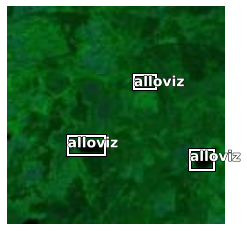

In [ ]:
#82. minta megjelenítése az annotációkkal
img = open_image(path/images[82])
bbox = ImageBBox.create(*img.size, lbl_bbox[82][0], [0,0,0], classes=['alloviz','alloviz','alloviz'])
img.show(figsize=(6,4), y=bbox)

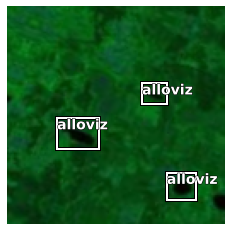

In [ ]:
#82. kép elforgatása 20°-al
img = img.rotate(-20)
bbox = bbox.rotate(-20)
img.show(figsize=(6,4), y=bbox)

In [ ]:
#dictionary készítése a képekből és a hozzátartozó annotációkból
img2bbox = dict(zip(images, lbl_bbox))
#képek nevének társítása a dictionary objektumához
get_y_func = lambda o:img2bbox[os.path.basename(o)]

In [ ]:
#databunch definiálása
#bs=batch size, size=képméret
def get_data(bs, size):
    src = ObjectItemList.from_folder(path)
    src = src.split_by_rand_pct(0.2) #20% validációs szett
    src = src.label_from_func(get_y_func) #labelek megadása
    src = src.transform(get_transforms(do_flip = True, flip_vert = False, max_lighting=0.1, max_zoom=1.1, 
                                       max_warp=0.1, max_rotate=25, p_affine=0.75, p_lighting=0.75), 
                        size=size, tfm_y=True)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)

In [ ]:
data = get_data(8,128)

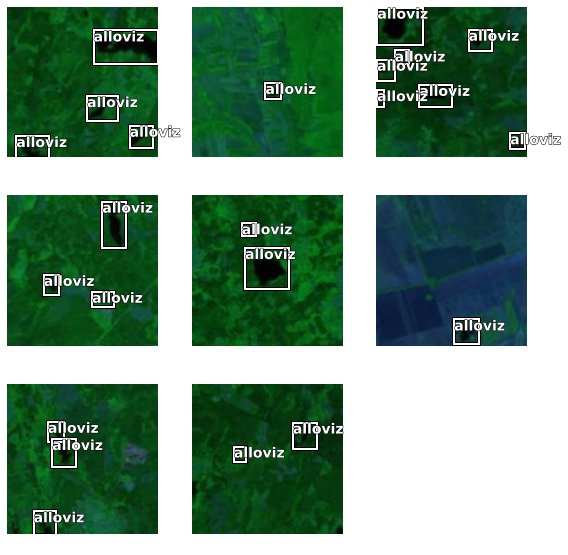

In [ ]:
data.show_batch(rows=3, figsize=(8,8))

In [ ]:
data.batch_stats()

[tensor([0.0584, 0.3300, 0.1290]), tensor([0.0687, 0.0889, 0.0854])]

# **RetinaNet model definiálása**

In [ ]:
#Segédfüggvények importja az U-alakú modell felépítéséhez
#Grab the convenience functions that helps us build the Unet
from fastai.vision.models.unet import _get_sfs_idxs, model_sizes, hook_outputs

In [ ]:
class LateralUpsampleMerge(nn.Module):
    "Merge the features coming from the downsample path (in `hook`) with the upsample path."
    def __init__(self, ch, ch_lat, hook):
        super().__init__()
        self.hook = hook
        self.conv_lat = conv2d(ch_lat, ch, ks=1, bias=True)
    
    def forward(self, x):
        return self.conv_lat(self.hook.stored) + F.interpolate(x, self.hook.stored.shape[-2:], mode='nearest')

In [ ]:
class RetinaNet(nn.Module):
    "Implements RetinaNet from https://arxiv.org/abs/1708.02002"
    def __init__(self, encoder:nn.Module, n_classes, final_bias=0., chs=256, n_anchors=9, flatten=True):
        super().__init__()
        self.n_classes,self.flatten = n_classes,flatten
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize) #sfs:save features, egy 256x256 képet helyez el a ResNet modellben, hogy kinyerje a különböző méretű aktivációkat
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs))) #_get_sfs_idxs: a rétegek fordított sorrendű indexét adja vissza ahol az aktiváció mérete megváltozik a tanulás során
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs]) #hook_o: visszaadja azokat a 'hook'-okat amelyek tárolják az aktivációkat a self.stored-ban
        self.encoder = encoder #encoder=ResNet, alább: a resnet utolsó réteg-eredménye (a fpn-ben c5)
        self.c5top5 = conv2d(sfs_szs[-1][1], chs, ks=1, bias=True)#conv2d: Create and initialize `nn.Conv2d` layer. `padding` defaults to `ks//2`.
        self.c5top6 = conv2d(sfs_szs[-1][1], chs, stride=2, bias=True)  
        self.p6top7 = nn.Sequential(nn.ReLU(), conv2d(chs, chs, stride=2, bias=True))
        self.merges = nn.ModuleList([LateralUpsampleMerge(chs, sfs_szs[idx][1], hook) 
                                     for idx,hook in zip(sfs_idxs[-2:-4:-1], self.sfs[-2:-4:-1])])
        self.smoothers = nn.ModuleList([conv2d(chs, chs, 3, bias=True) for _ in range(3)])
        self.classifier = self._head_subnet(n_classes, n_anchors, final_bias, chs=chs) #osztályozó alkalmazása a helper függvény beállításai alapján
        self.box_regressor = self._head_subnet(4, n_anchors, 0., chs=chs) #keretek meghatározása a helper függvény beállításai alapján
    
    # ("Each P-something feature map then goes through two subnet of four convolutional layers (with the same weights for all the feature maps)")
    def _head_subnet(self, n_classes, n_anchors, final_bias=0., n_conv=4, chs=256):
        "Helper function to create one of the subnet for regression/classification."
        layers = [conv_layer(chs, chs, bias=True, norm_type=None) for _ in range(n_conv)] #conv_layer: (4x) Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and batchnorm (if `bn`) layers.
        layers += [conv2d(chs, n_classes * n_anchors, bias=True)]
        layers[-1].bias.data.zero_().add_(final_bias) #bias alkalmazása a rétegekhez
        layers[-1].weight.data.fill_(0) #súly módsoítás
        return nn.Sequential(*layers)

    #flattens the output of our final convolutional layers that predict boxes/classes:
    def _apply_transpose(self, func, p_states, n_classes):
        #Final result of the classifier/regressor is bs * (k * n_anchors) * h * w  (k itt osztályok száma)
        #We make it bs * h * w * n_anchors * k then flatten in bs * -1 * k so we can contenate
        #all the results in bs * anchors * k (the non flatten version is there for debugging only)
        if not self.flatten: 
            sizes = [[p.size(0), p.size(2), p.size(3)] for p in p_states]
            return [func(p).permute(0,2,3,1).view(*sz,-1,n_classes) for p,sz in zip(p_states,sizes)]
        else:
            return torch.cat([func(p).permute(0,2,3,1).contiguous().view(p.size(0),-1,n_classes) for p in p_states],1)
    
    def forward(self, x):
        c5 = self.encoder(x)
        p_states = [self.c5top5(c5.clone()), self.c5top6(c5)]
        p_states.append(self.p6top7(p_states[-1]))
        for merge in self.merges: p_states = [merge(p_states[0])] + p_states
        for i, smooth in enumerate(self.smoothers[:3]):
            p_states[i] = smooth(p_states[i])
        return [self._apply_transpose(self.classifier, p_states, self.n_classes), 
                self._apply_transpose(self.box_regressor, p_states, 4),
                [[p.size(2), p.size(3)] for p in p_states]]
    
    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

# **Segédfüggvények**

**Encore boxes:** The most basic way to map one of these features with an actual area inside the image is to create the regular 4 by 4 grid. Our convention is that y is first (like in numpy or PyTorch), and that all coordinates are scaled from -1 to 1 (-1 being top/right, 1 being bottom/left).

Koordináta rácshálózat létrehozása, hogy a későbbi kereteket kirajzolja

In [ ]:
def create_grid(size):
    "Create a grid of a given `size`."
    H, W = size if is_tuple(size) else (size,size) #grid méret beállítása
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])# létrehoz egyforma távolságban lévő pontokat
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

In [ ]:
#függvény a horgonyok kirajzolására
def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5)) #ábrakészítés a horgonyok ábrázolásra
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid()
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

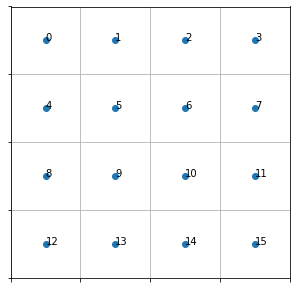

In [ ]:
size = (4,4)
show_anchors(create_grid(size), size)

In [ ]:
def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    #In practice, we use different ratios and scales of that basic grid to build our anchors, 
    #because bounding boxes aren't always a perfect square inside a grid.
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
    for h,w in sizes:
        #4 here to have the anchors overlap.
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0) #új tensort ad vissza a megadott érték dimenziójában
        base_grid = create_grid((h,w)).unsqueeze(1)
        n,a = base_grid.size(0),aspects.size(0)
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2) #cat: összefűzi a megadott tensorokat
        anchors.append(ancs.view(h,w,a,4))
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

In [ ]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)] 
#Paper used [1,2**(1/3), 2**(2/3)] but a bigger size (600) too, so the largest feature map gave anchors that cover less of the image.
sizes = [(2**i,2**i) for i in range(5)]
sizes.reverse() #Predictions come in the order of the smallest feature map to the biggest
anchors = create_anchors(sizes, ratios, scales)

In [ ]:
anchors.size()

torch.Size([3069, 4])

In [ ]:
#Keretek kirajzolási beállításai
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    #colormap megjelenítése a kerethez
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_color = 12
cmap = get_cmap(num_color)
color_list = [cmap(float(x)) for x in range(num_color)]

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [ ]:
def show_boxes(boxes):
    "Show the `boxes` (size by 4)"
    _, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1)
    for i, bbox in enumerate(boxes):
        bb = bbox.numpy()
        rect = [bb[1]-bb[3]/2, bb[0]-bb[2]/2, bb[3], bb[2]]
        draw_rect(ax, rect, color=color_list[i%num_color])
        draw_text(ax, [bb[1]-bb[3]/2,bb[0]-bb[2]/2], str(i), color=color_list[i%num_color])

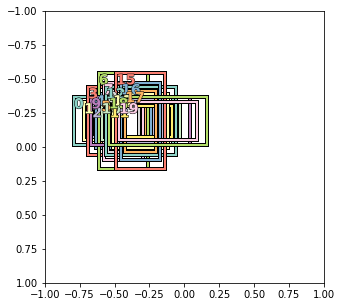

In [ ]:
show_boxes(anchors[900:920]) #20 doboz megjelenítése

In [ ]:
#Modell aktivációk átvétele
def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    #vagyis: átkonvertálja az anchors-ban határolt aktivációkat a modellből
    if flatten:
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]])) #Can't remember where those scales come from, but they help regularize
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2] #Itt minden box a megadott értékek szerint tolható el valamelyik irányban
        sizes = anchors[...,2:] * torch.exp(acts[...,:2]) #Itt pedig méretében növelhető, csökkenthető a megadottak alapján
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [ ]:
size=(4,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = torch.randn(size[0]*size[1], 4) * 0.1
bboxes = activ_to_bbox(activations, anchors)

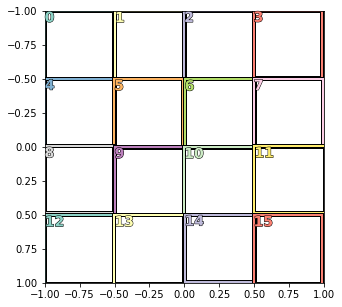

In [ ]:
show_boxes(bboxes)

In [ ]:
def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

In [ ]:
def intersection(anchors, targets):
    "Compute the sizes of the intersections of `anchors` by `targets`."
    #compute the intersection over unions ratios between all the anchors and all the targets, 
    #then we will keep the ones that have an overlap greater than a given threshold (0.5).
    ancs, tgts = cthw2tlbr(anchors), cthw2tlbr(targets)
    a, t = ancs.size(0), tgts.size(0)
    ancs, tgts = ancs.unsqueeze(1).expand(a,t,4), tgts.unsqueeze(0).expand(a,t,4)
    top_left_i = torch.max(ancs[...,:2], tgts[...,:2])
    bot_right_i = torch.min(ancs[...,2:], tgts[...,2:])
    sizes = torch.clamp(bot_right_i - top_left_i, min=0) #összefogja az anchor/target különbségeket és a részarányos értékeket adja vissza
    return sizes[...,0] * sizes[...,1]

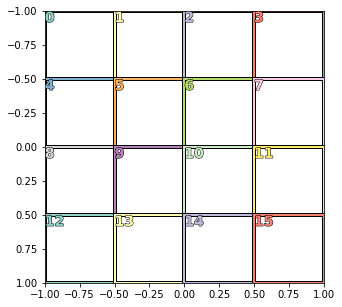

In [ ]:
show_boxes(anchors)

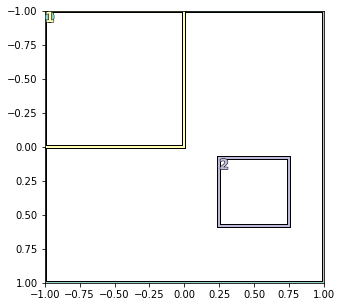

In [ ]:
#Itt a target (=label) random értékekkel megadva
targets = torch.tensor([[0.,0.,2.,2.], [-0.5,-0.5,1.,1.], [1/3,0.5,0.5,0.5]])
show_boxes(targets)

In [ ]:
intersection(anchors, targets)

tensor([[0.0996, 0.0996, 0.0000],
        [0.0696, 0.0696, 0.0000],
        [0.0496, 0.0496, 0.0000],
        ...,
        [4.0000, 1.0000, 0.2500],
        [4.0000, 1.0000, 0.2500],
        [4.0000, 1.0000, 0.2500]])

In [ ]:
def IoU_values(anchors, targets):
    "Compute the IoU VALUES! of `anchors` by `targets`."
    #The Intersection over Union (IoU) is a method to quantify the percent overlap between the target mask and our prediction output.
    inter = intersection(anchors, targets)
    anc_sz, tgt_sz = anchors[:,2] * anchors[:,3], targets[:,2] * targets[:,3]
    union = anc_sz.unsqueeze(1) + tgt_sz.unsqueeze(0) - inter
    return inter/(union+1e-8)

In [ ]:
IoU_values(anchors, targets)

tensor([[0.0625, 0.2500, 0.0000],
        [0.0625, 0.2500, 0.0000],
        [0.0625, 0.0000, 0.0000],
        [0.0625, 0.0000, 0.0000],
        [0.0625, 0.2500, 0.0000],
        [0.0625, 0.2500, 0.0000],
        [0.0625, 0.0000, 0.0000],
        [0.0625, 0.0000, 0.0000],
        [0.0625, 0.0000, 0.0000],
        [0.0625, 0.0000, 0.0000],
        [0.0625, 0.0000, 0.2632],
        [0.0625, 0.0000, 0.2632],
        [0.0625, 0.0000, 0.0000],
        [0.0625, 0.0000, 0.0000],
        [0.0625, 0.0000, 0.0435],
        [0.0625, 0.0000, 0.0435]])

In [ ]:
#A legpontosabb keretek megtartása az IoU eredményekből (kommentelt)
def match_anchors(anchors, targets, match_thr=0.5, bkg_thr=0.4):
    "Match `anchors` to targets. -1 is match to background, -2 is ignore."
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
    if targets.numel() == 0: return matches
    ious = IoU_values(anchors, targets)
    vals,idxs = torch.max(ious,1)
    matches[vals < bkg_thr] = -1
    matches[vals > match_thr] = idxs[vals > match_thr]
    #Overwrite matches with each target getting the anchor that has the max IoU.
    #vals,idxs = torch.max(ious,0)
    #If idxs contains repetition, this doesn't bug and only the last is considered.
    #matches[idxs] = targets.new_tensor(list(range(targets.size(0)))).long()
    return matches

In [ ]:
match_anchors(anchors, targets)

tensor([ 0,  1,  2,  3, -2])

In [ ]:
#With anchors very close to the targets.
size=(4,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = 0.1 * torch.randn(size[0]*size[1], 4)
bboxes = activ_to_bbox(activations, anchors)
match_anchors(anchors,bboxes)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [ ]:
#With anchors in the grey area.
anchors = create_grid((2,2))
anchors = torch.cat([anchors, torch.tensor([1.,1.]).expand_as(anchors)], 1)
targets = anchors.clone()
anchors = torch.cat([anchors, torch.tensor([[-0.5,0.,1.,1.8]])], 0)
match_anchors(anchors,targets)

tensor([ 0,  1,  2,  3, -2])

In [ ]:
#Does the opposite of cthw2tbr.
def tlbr2cthw(boxes):
    "Convert top/left bottom/right format `boxes` to center/size corners."
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)

In [ ]:
#Does the opposite of activ_to_bbox.
def bbox_to_activ(bboxes, anchors, flatten=True):
    "Return the target of the model on `anchors` for the `bboxes`."
    if flatten:
        t_centers = (bboxes[...,:2] - anchors[...,:2]) / anchors[...,2:] 
        t_sizes = torch.log(bboxes[...,2:] / anchors[...,2:] + 1e-8) 
        return torch.cat([t_centers, t_sizes], -1).div_(bboxes.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [ ]:
def encode_class(idxs, n_classes):
    #A targetet one-hot encoded formába alakítja át
    target = idxs.new_zeros(len(idxs), n_classes).float()
    mask = idxs != 0
    i1s = LongTensor(list(range(len(idxs))))
    target[i1s[mask],idxs[mask]-1] = 1
    return target

In [ ]:
encode_class(LongTensor([1,2,0,1,3]),3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.]])

In [ ]:
#RetinaNet Focal Loss felépítése
class RetinaNetFocalLoss(nn.Module):
    
    def __init__(self, gamma:float=2., alpha:float=0.25,  pad_idx:int=0, scales:Collection[float]=None, 
                 ratios:Collection[float]=None, reg_loss:LossFunction=F.smooth_l1_loss):
        super().__init__()
        self.gamma,self.alpha,self.pad_idx,self.reg_loss = gamma,alpha,pad_idx,reg_loss
        self.scales = ifnone(scales, [1,2**(-1/3), 2**(-2/3)])
        self.ratios = ifnone(ratios, [1/2,1,2])
        
    def _change_anchors(self, sizes:Sizes) -> bool:
        if not hasattr(self, 'sizes'): return True
        for sz1, sz2 in zip(self.sizes, sizes):
            if sz1[0] != sz2[0] or sz1[1] != sz2[1]: return True
        return False
    
    def _create_anchors(self, sizes:Sizes, device:torch.device):
        self.sizes = sizes
        self.anchors = create_anchors(sizes, self.ratios, self.scales).to(device)
    
    def _unpad(self, bbox_tgt, clas_tgt):
        i = torch.min(torch.nonzero(clas_tgt-self.pad_idx))
        return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:]-1+self.pad_idx
    
    def _focal_loss(self, clas_pred, clas_tgt):
        encoded_tgt = encode_class(clas_tgt, clas_pred.size(1))
        ps = torch.sigmoid(clas_pred.detach())
        weights = encoded_tgt * (1-ps) + (1-encoded_tgt) * ps
        alphas = (1-encoded_tgt) * self.alpha + encoded_tgt * (1-self.alpha)
        weights.pow_(self.gamma).mul_(alphas)
        clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights, reduction='sum')
        return clas_loss
        
    def _one_loss(self, clas_pred, bbox_pred, clas_tgt, bbox_tgt):
        bbox_tgt, clas_tgt = self._unpad(bbox_tgt, clas_tgt)
        matches = match_anchors(self.anchors, bbox_tgt)
        bbox_mask = matches>=0
        if bbox_mask.sum() != 0:
            bbox_pred = bbox_pred[bbox_mask]
            bbox_tgt = bbox_tgt[matches[bbox_mask]]
            bb_loss = self.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, self.anchors[bbox_mask]))
        else: bb_loss = 0.
        matches.add_(1)
        clas_tgt = clas_tgt + 1
        clas_mask = matches>=0
        clas_pred = clas_pred[clas_mask]
        clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
        clas_tgt = clas_tgt[matches[clas_mask]]
        return bb_loss + self._focal_loss(clas_pred, clas_tgt)/torch.clamp(bbox_mask.sum(), min=1.)
    
    def forward(self, output, bbox_tgts, clas_tgts):
        clas_preds, bbox_preds, sizes = output
        if self._change_anchors(sizes): self._create_anchors(sizes, clas_preds.device)
        n_classes = clas_preds.size(2)
        return sum([self._one_loss(cp, bp, ct, bt)
                    for (cp, bp, ct, bt) in zip(clas_preds, bbox_preds, clas_tgts, bbox_tgts)])/clas_tgts.size(0)

In [ ]:
class SigmaL1SmoothLoss(nn.Module):

    def forward(self, output, target):
        reg_diff = torch.abs(target - output)
        reg_loss = torch.where(torch.le(reg_diff, 1/9), 4.5 * torch.pow(reg_diff, 2), reg_diff - 1/18)
        return reg_loss.mean()

# **Betanítási fázis**

In [ ]:
#Doboz arányok és méretek a hivatalos cikk szerinti paraméterekkel
ratios = [1/2,1,2] # oldalarány
scales = [1,2**(-1/3), 2**(-2/3)] # oldalméret
#scales = [1,2**(1/3), 2**(2/3)] for bigger size

In [ ]:
encoder = create_body(models.resnet50, cut=-2)
model = RetinaNet(encoder, data.c, final_bias=-4)
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)
learn = Learner(data, model, loss_func=crit)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
torch.sigmoid(tensor([-4.]))

tensor([0.0180])

In [ ]:
#Modell szétválasztása az adaptív tanuláshoz
def retina_net_split(model):
    groups = [list(model.encoder.children())[:6], list(model.encoder.children())[6:]]
    return groups + [list(model.children())[1:]]

In [ ]:
learn = learn.split(retina_net_split)

In [ ]:
#A rétegek fagyasztása az utolsó réteg kivételével
learn.freeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,3.454214,#na#,00:01
1,3.333580,#na#,00:01
2,3.145911,#na#,00:01


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


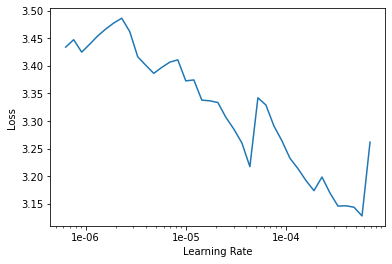

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit(5, 1e-4)

epoch,train_loss,valid_loss,time
0,2.702464,3.597025,00:02
1,2.376029,3.583953,00:02
2,2.245751,2.630893,00:02
3,2.178862,3.318576,00:02
4,2.114774,2.348571,00:02


In [ ]:
learn.save('allapot1')

In [ ]:
#unfreeze, hogy a teljes datasetet tanítsuk
learn.unfreeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,1.776021,#na#,00:02
1,1.762318,#na#,00:02
2,1.764188,#na#,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


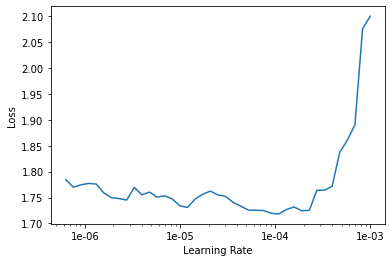

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, slice(2e-6, 1e-4))

epoch,train_loss,valid_loss,time
0,1.762535,2.413274,00:02
1,1.734014,2.077169,00:02
2,1.666277,1.973485,00:02
3,1.605030,1.612373,00:02
4,1.427814,1.265922,00:02
5,1.307412,1.325664,00:02
6,1.186422,1.100495,00:02
7,1.102688,1.006321,00:02
8,1.032112,1.019428,00:02
9,0.970356,0.982147,00:02


In [ ]:
learn.save('allapot2')

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.848426,#na#,00:02
1,0.808502,#na#,00:02
2,0.776065,#na#,00:02
3,1.968588,#na#,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


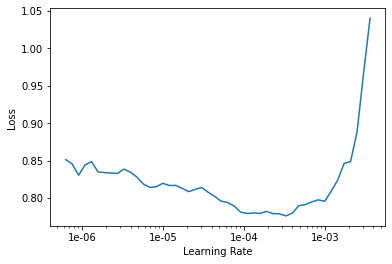

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, slice(2e-6, 1e-4))

epoch,train_loss,valid_loss,time
0,0.828531,0.933686,00:02
1,0.822446,0.931343,00:02
2,0.843868,0.929808,00:02
3,0.827109,0.973800,00:02
4,0.784721,0.824036,00:02
5,0.769565,0.783015,00:02
6,0.741256,0.805700,00:02
7,0.724642,0.805380,00:02
8,0.693274,0.810786,00:02
9,0.671649,0.788759,00:02


In [ ]:
learn.save('allapot3')

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.614328,#na#,00:02
1,0.608205,#na#,00:02
2,0.601846,#na#,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


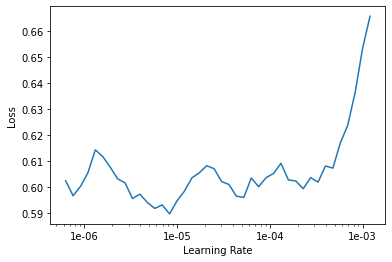

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, 2e-4))

epoch,train_loss,valid_loss,time
0,0.602300,0.740421,00:02
1,0.629709,0.931514,00:02
2,0.639780,0.753236,00:02
3,0.643132,0.759995,00:02
4,0.622739,0.715146,00:02


In [ ]:
learn.fit_one_cycle(5, slice(1e-5, 2e-4))

epoch,train_loss,valid_loss,time
0,0.586760,0.707663,00:02
1,0.571162,0.854483,00:02
2,0.609563,0.736198,00:02
3,0.598517,0.691145,00:02
4,0.605263,0.687049,00:02


In [ ]:
learn.save('allapot4')

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.559630,#na#,00:02
1,0.549144,#na#,00:02
2,0.657155,#na#,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


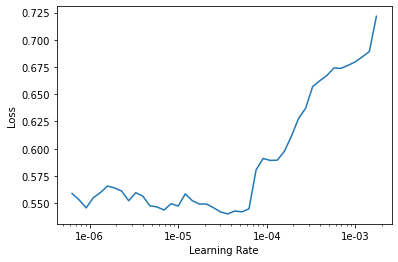

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8, slice(7e-7, 4e-5))

epoch,train_loss,valid_loss,time
0,0.546848,0.643506,00:02
1,0.505643,0.653160,00:02
2,0.498220,0.634106,00:02
3,0.495925,0.637039,00:02
4,0.503069,0.642929,00:02
5,0.500505,0.640250,00:02
6,0.487862,0.625266,00:02
7,0.482130,0.610556,00:02


In [ ]:
learn.save('allapot5')

In [ ]:
learn.fit_one_cycle(8, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,time
0,0.557869,0.670810,00:02
1,0.505272,0.609535,00:02
2,0.499382,0.632763,00:02
3,0.507397,0.633411,00:02
4,0.488080,0.625671,00:02
5,0.480439,0.596849,00:02
6,0.467443,0.596038,00:02
7,0.453102,0.617167,00:02


In [ ]:
learn.save('allapot5_1')

In [ ]:
learn.fit_one_cycle(8, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,time
0,0.429253,0.601304,00:02
1,0.412685,0.603740,00:02
2,0.452253,0.847417,00:02
3,0.464758,0.613100,00:02
4,0.469438,0.648028,00:02
5,0.478799,0.552498,00:02
6,0.466783,0.573960,00:02
7,0.448426,0.560254,00:02


In [ ]:
#check: 75%
learn.save('allapot5_2')

In [ ]:
learn.fit_one_cycle(8, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,time
0,0.400676,0.558097,00:02
1,0.415419,0.593758,00:02
2,0.448547,0.572612,00:02
3,0.442672,0.599344,00:02
4,0.431096,0.560053,00:02
5,0.420402,0.548186,00:02
6,0.413072,0.537231,00:02
7,0.408497,0.517091,00:02


In [ ]:
#check: 77,1%
learn.save('allapot5_3')

In [ ]:
learn.fit_one_cycle(8, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,time
0,0.348183,0.533921,00:02
1,0.362943,0.571091,00:02
2,0.374602,0.533949,00:02
3,0.384427,0.568429,00:02
4,0.389150,0.589191,00:02
5,0.387842,0.572378,00:02
6,0.380467,0.531581,00:02
7,0.379031,0.520282,00:02


In [ ]:
#67% rosszabb..
learn.save('allapot5_4')

In [ ]:
learn.load('allapot5_3')

Learner(data=ImageDataBunch;

Train: LabelList (120 items)
x: ObjectItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ObjectCategoryList
ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128)
Path: /content/data_sved_2/JPEGImages;

Valid: LabelList (29 items)
x: ObjectItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ObjectCategoryList
ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128)
Path: /content/data_sved_2/JPEGImages;

Test: None, model=RetinaNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  

In [ ]:
#magasabb lr használata, de így is rossz 
#eredmény (52%) -> további tanulás overfit
learn.fit_one_cycle(8,slice(1e-5,5e-4))

epoch,train_loss,valid_loss,time
0,0.359088,0.674929,00:02
1,0.445129,0.970863,00:02
2,0.758036,5.320627,00:02
3,1.466717,1.602087,00:02
4,1.367111,1.025201,00:02
5,1.190412,0.828509,00:02
6,1.037824,0.767114,00:02
7,0.905240,0.747561,00:02


# **Eredmények vizsgálata**

In [ ]:
#A validációs szett képeinek betöltése
img,target = next(iter(data.valid_dl))
# torch.no_grad() impacts the autograd engine and deactivate it. It will reduce memory usage and speed up
with torch.no_grad():
    output = learn.model(img)

In [ ]:
def unpad(tgt_bbox, tgt_clas, pad_idx=0):
    #to remove padding that was added to collate our targets together
    i = torch.min(torch.nonzero(tgt_clas-pad_idx))
    return tlbr2cthw(tgt_bbox[i:]), tgt_clas[i:]-1+pad_idx

In [ ]:
#Predikciók számítása a valid szett képein
def process_output(output, i, detect_thresh=0.25):
    "Process `output[i]` and return the predicted bboxes above `detect_thresh`."
    #convert the activations of the regressor to bounding boxes and the predictions to probabilities, 
    #only keeping those above a given threshold.
    clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds

In [ ]:
#Helper functions to plot the results
def _draw_outline(o:Patch, lw:int):
    "Outline bounding box onto image `Patch`."
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax:plt.Axes, b:Collection[int], color:str='white', text=None, text_size=14):
    "Draw bounding box on `ax`."
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(*b[:2], text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)

In [ ]:
#Megjeleníti a validációs szett képeinek predikcióit
def show_preds(img, output, idx, detect_thresh=0.25, classes=None):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    bbox_pred, preds, scores = bbox_pred.cpu(), preds.cpu(), scores.cpu()
    t_sz = torch.Tensor([*img.size])[None].float()
    bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
    bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
    bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
    bbox_pred = bbox_pred.long()
    _, ax = plt.subplots(1,1)
    for bbox, c, scr in zip(bbox_pred, preds, scores):
        img.show(ax=ax)
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')

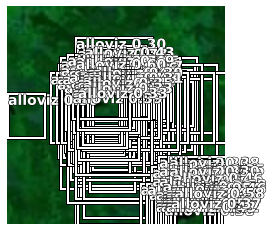

In [ ]:
#Eredmény próba egy mintán, itt még minden predikció megjelenik ezt szűkiteni kell
idx = 7
img = data.valid_ds[idx][0]
show_preds(img, output, idx, detect_thresh=0.3, classes=data.classes)

In [ ]:
def nms(boxes, scores, thresh=0.3):
    #függvény a predikciók számának csökkentésére
    idx_sort = scores.argsort(descending=True)
    boxes, scores = boxes[idx_sort], scores[idx_sort]
    to_keep, indexes = [], torch.LongTensor(range_of(scores))
    while len(scores) > 0:
        to_keep.append(idx_sort[indexes[0]])
        iou_vals = IoU_values(boxes, boxes[:1]).squeeze()
        mask_keep = iou_vals < thresh
        if len(mask_keep.nonzero()) == 0: break
        boxes, scores, indexes = boxes[mask_keep], scores[mask_keep], indexes[mask_keep]
    return LongTensor(to_keep)

In [ ]:
def process_output(output, i, detect_thresh=0.25):
    clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    if clas_pred.numel() == 0: return [],[],[]
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds

In [ ]:
def show_preds(img, output, idx, detect_thresh=0.25, classes=None, ax=None):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    if len(scores) != 0:
        to_keep = nms(bbox_pred, scores)
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()
        t_sz = torch.Tensor([*img.size])[None].float()
        bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
        bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
        bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz/2
        bbox_pred = bbox_pred.long()
    if ax is None: _, ax = plt.subplots(1,1)
    img.show(ax=ax)
    for bbox, c, scr in zip(bbox_pred, preds, scores):
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')

In [ ]:
def show_results(learn, start=0, n=5, detect_thresh=0.35, figsize=(10,25)):
    x,y = learn.data.one_batch(DatasetType.Valid, cpu=False)
    with torch.no_grad():
        z = learn.model.eval()(x)
    _,axs = plt.subplots(n, 2, figsize=figsize)
    for i in range(n):
        img,bbox = learn.data.valid_ds[start+i]
        img.show(ax=axs[i,0], y=bbox)
        show_preds(img, z, start+i, detect_thresh=detect_thresh, classes=learn.data.classes, ax=axs[i,1])

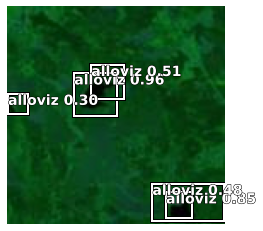

In [ ]:
#eredmény próba egy mintán, már szűkített predikció
idx = 7
img = data.valid_ds[idx][0]
show_preds(img, output, idx, detect_thresh=0.3, classes=data.classes)

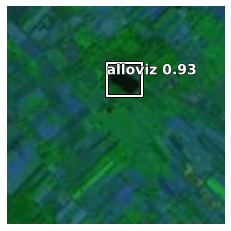

In [ ]:
idx = 6
img = data.valid_ds[idx][0]
show_preds(img, output, idx, detect_thresh=0.3, classes=data.classes)

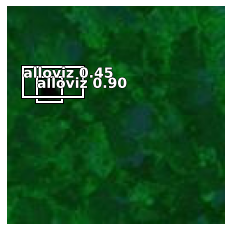

In [ ]:
idx = 5
img = data.valid_ds[idx][0]
show_preds(img, output, idx, detect_thresh=0.3, classes=data.classes)

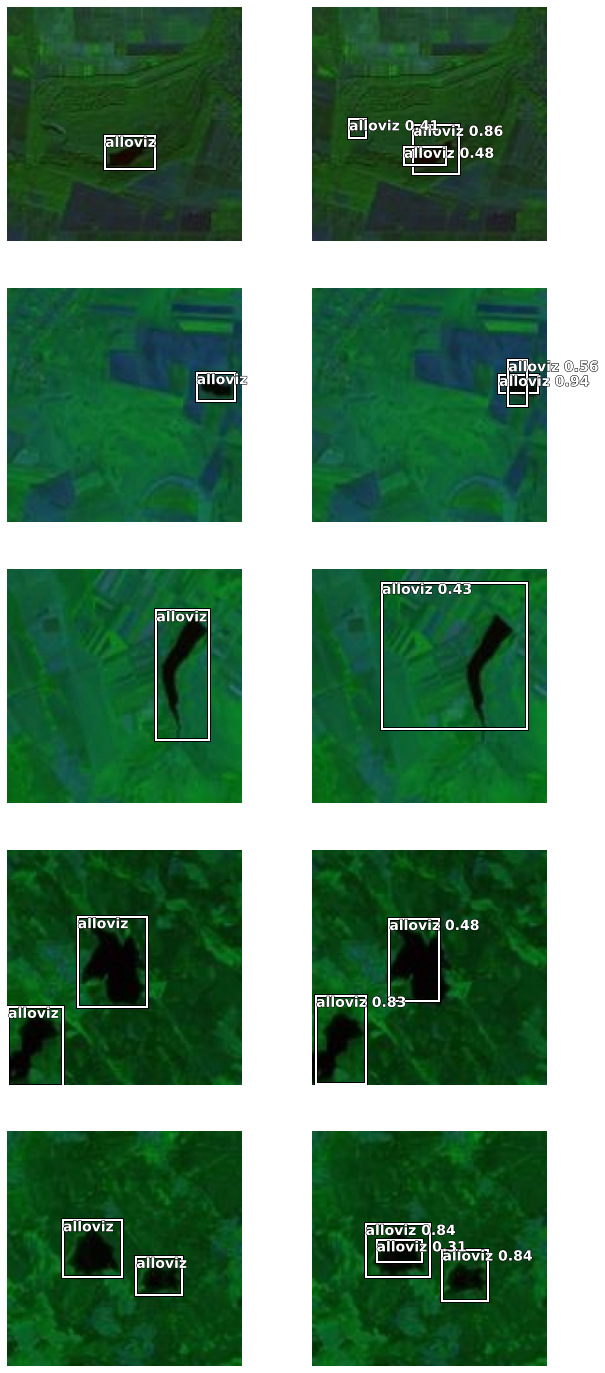

In [ ]:
 #5.3-as modell eredmények
 show_results(learn, detect_thresh=0.3)

# **mAP: mean Average Precision**

**mAP: mean Average Precision**
It relies on computing the cumulated precision and recall for each class, then tries to compute the area under the precision/recall curve we can draw.

In [ ]:
#A validációs szett predikcióit tölti be az mAP-hez
def get_predictions(output, idx, detect_thresh=0.05):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    if len(scores) == 0: return [],[],[]
    to_keep = nms(bbox_pred, scores) #keep nms
    return bbox_pred[to_keep], preds[to_keep], scores[to_keep]

In [ ]:
get_predictions(output, 5)

(tensor([[-0.2190, -0.5939,  0.2497,  0.2498],
         [-0.3118, -0.6869,  0.3157,  0.3155],
         [-0.2810, -0.6560,  0.1577,  0.1577],
         [-0.1880, -0.5629,  0.4995,  0.4996],
         [-0.2811, -0.5939,  0.2229,  0.1112],
         [-0.2189, -0.6560,  0.1112,  0.2230],
         [-0.9565,  0.3437,  0.0871,  0.2227],
         [-0.6874,  0.6875,  0.3150,  0.3150],
         [-0.3119, -0.4382,  0.3155,  0.3143],
         [-0.3432, -0.5939,  0.1409,  0.2805],
         [-0.1566, -0.6560,  0.1572,  0.1577],
         [ 0.4378,  0.1876,  0.3152,  0.3150],
         [-0.9564, -0.4687,  0.0871,  0.2228],
         [-0.6875, -0.3126,  0.3150,  0.3149],
         [ 0.0313, -0.4687,  0.1575,  0.1575],
         [ 0.4378,  0.3124,  0.4457,  0.2227],
         [-0.2190, -0.7183,  0.2804,  0.1408],
         [-0.5626,  0.6875,  0.2226,  0.4455],
         [-0.7187, -0.9565,  0.2227,  0.0870],
         [-0.4361, -0.5626,  0.5626,  0.2805],
         [ 0.0313,  0.3438,  0.1575,  0.1575],
         [-0.

In [ ]:
#pascal
def compute_ap(precision, recall):
    "Compute the average precision for `precision` and `recall` curve."
    recall = np.concatenate(([0.], list(recall), [1.]))
    precision = np.concatenate(([0.], list(precision), [0.]))
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])
    idx = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[idx + 1] - recall[idx]) * precision[idx + 1])
    return ap

In [ ]:
#pascal
def compute_class_AP(model, dl, n_classes, iou_thresh=0.5, detect_thresh=0.35, num_keep=100):
    tps, clas, p_scores = [], [], []
    classes, n_gts = LongTensor(range(n_classes)),torch.zeros(n_classes).long()
    with torch.no_grad():
        for input,target in progress_bar(dl):
            output = model(input)
            for i in range(target[0].size(0)):
                bbox_pred, preds, scores = get_predictions(output, i, detect_thresh)
                tgt_bbox, tgt_clas = unpad(target[0][i], target[1][i])
                if len(bbox_pred) != 0 and len(tgt_bbox) != 0:
                    ious = IoU_values(bbox_pred, tgt_bbox)
                    max_iou, matches = ious.max(1)
                    detected = []
                    for i in range_of(preds):
                        if max_iou[i] >= iou_thresh and matches[i] not in detected and tgt_clas[matches[i]] == preds[i]:
                            detected.append(matches[i])
                            tps.append(1)
                        else: tps.append(0)
                    clas.append(preds.cpu())
                    p_scores.append(scores.cpu())
                n_gts += (tgt_clas.cpu()[:,None] == classes[None,:]).sum(0)
    tps, p_scores, clas = torch.tensor(tps), torch.cat(p_scores,0), torch.cat(clas,0)
    fps = 1-tps
    idx = p_scores.argsort(descending=True)
    tps, fps, clas = tps[idx], fps[idx], clas[idx]
    aps = []
    #return tps, clas
    for cls in range(n_classes):
        tps_cls, fps_cls = tps[clas==cls].float().cumsum(0), fps[clas==cls].float().cumsum(0)
        if tps_cls.numel() != 0 and tps_cls[-1] != 0:
            precision = tps_cls / (tps_cls + fps_cls + 1e-8)
            recall = tps_cls / (n_gts[cls] + 1e-8)
            aps.append(compute_ap(precision, recall))
        else: aps.append(0.)
    return aps

In [ ]:
#pascal
L = compute_class_AP(learn.model, data.valid_dl, data.c-1)

In [ ]:
#Átlag-pontosság az alloviz osztályra
#allapot3: 44,3%
#allapot4: 48,7%
#allapot5: 61,9%
#allapot5_2: 75,7%
#allapot5_3: 77,1%
#allapot5_4: 67,6% kisebb lr
#allapot5_4: 52,8% nagyobb lr, mindkettő pontatlan -> overfit ?!
for ap,cl in zip(L, data.classes[1:]): print(f'{cl}: {ap:.6f}')

alloviz: 0.891035


# Modell mentése drivera és visszatöltése driveról




In [ ]:
#Mount drivera (és alább mentés)
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#Model tárolása változóban
model_save_name = 'allapot5_3_sved_szukitett_alloviz_77p.pt'
drive_path = F"/content/gdrive/My Drive/Diplomamunka/{model_save_name}"

In [ ]:
#(csak betanítás után futtatni!)
#Model mentése drivera
torch.save(model.state_dict(), drive_path)

In [ ]:
#Visszatöltés driveról
model.load_state_dict(torch.load(drive_path))

<All keys matched successfully>

In [ ]:
#Mentés tmp fájlba a használatra
learn.save('model_from_drive_1')

In [ ]:
learn.load('model_from_drive_1')
learn.model.eval()

RetinaNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

# Referenciák


- fastai pascal bbox: https://github.com/fastai/course-v3/blob/master/nbs/dl2/pascal.ipynb
- Stas Bekman notebook: https://github.com/fastai/fastai_dev/blob/master/dev_nb/102a_coco.ipynb
- json: https://medium.com/datadriveninvestor/how-to-create-custom-coco-data-set-for-object-detection-96ec91958f36
- databunch összeállítás: https://colab.research.google.com/drive/1amQNxHq9Zk0WcKugqw02KcOQ6lMhuztI#scrollTo=Ekf__1VGJ-Yj